<center>
<img src='Deerns-logo.jpg' height="100">
<center/>

# COP Calculator



In [10]:
import inputs
import refdata as ref
import isentropic_efficiency as isen
import scopcalc
import numpy
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt

### Log p-h diagram

The thermodynamic properties of refrigerants used in heat pumps can be visualised in a log p-h diagram. The pressure is plotted on a logarithmic scale against the enthalpy (energy content) of the refrigerant. Log p-h diagrams are used in refrigeration technology to determine thermodynamic properties in a refrigeration cycle to evaluate its performance.\
\
 The log p-h diagram consists of a couple of important features:
- The quasi bell-shaped curve (saturation curve) in the middle of the graph indicates where the refrigerant is in a saturated state: either saturated liquid (bubble point) or saturated gas (dew point). 
- On the left side of the saturation curve, the refrigerant is in liquid phase, subcooled below its saturation temperature. 
- On the right side of the saturation curve the refrigerant is in gasseous state, superheated above its saturation temperature. 
- The area underneath the saturation curve indicates a two-phase zone, where both liquid and gasseous phases exist. Accordingly, this is the region where evaporation and condensation of the refrigerant takes place. The temperature in this region stays constant at constant pressure while the energy content rises due to the absorbing of latent heat.

In [11]:
# Plotting saturation curve
fig, ax = plt.subplots()

toplot_h_liq = ref.enthalpy_liquid_saturated
toplot_h_gas = ref.enthalpy_gas_saturated

toplot_p_gas = ref.pressure_saturated_gas
toplot_p_liq = ref.pressure_saturated_liq

ax.plot(toplot_h_liq, toplot_p_liq, color='k')
ax.plot(toplot_h_gas, toplot_p_gas, color='k')

plt.yscale('log')
plt.xlabel("Enthalpy (kJ/kg)")
plt.ylabel("Pressure (bar)")
plt.title("Log p-h diagram for refrigerant " + inputs.refrigerant)
plt.grid(which = 'minor', linewidth=0.2)
plt.grid(which = 'major', linewidth=1)
plt.ylim(1, max(toplot_p_gas + 10))
plt.close(fig)

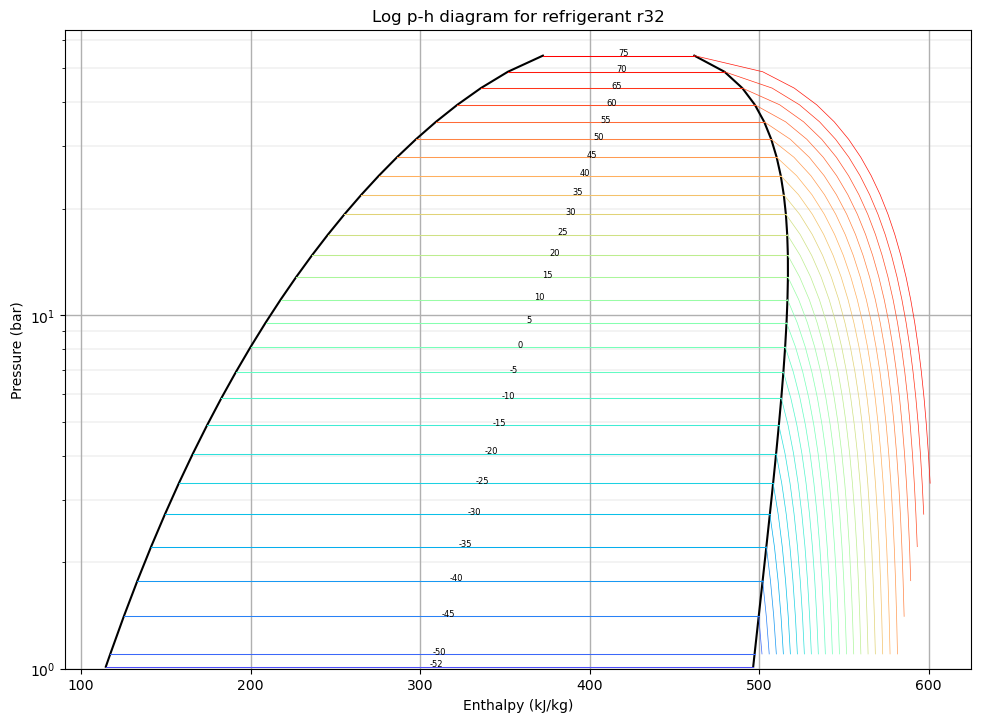

In [12]:
# Plotting temperature lines
# Two phase region
toploth_sat_templine_l = ref.saturated_refrigerant_data['Enthalpy_liq']
toploth_sat_templine_g = ref.enthalpy_gas_saturated_func(toplot_p_gas)
toplot_label = ref.saturated_refrigerant_data['Temp_liq']
color = iter(plt.cm.rainbow(numpy.linspace(0.1, 1, len(toplot_p_gas))))

for xl, xg, yl, yg, label in zip(toploth_sat_templine_l, toploth_sat_templine_g, toplot_p_liq, toplot_p_gas, toplot_label):
    setcolor = next(color)
    ax.plot([xl,xg],[yl,yg], c = setcolor, linewidth = 0.75)

    label_x = xl + ((xg-xl) / 2)
    label_y = yl + ((yg-yl) / 2)
    ax.annotate(str(round(label)),xy=(label_x, label_y), size = 6)
    
# Superheated region
mydata = ref.superheated_refrigerant_data

for myvalue in mydata.Temperature: 
    if not float(myvalue).is_integer() or myvalue > max(toplot_label):
        mydata =  mydata.drop(mydata.index[mydata.Temperature == myvalue])
        
grouped = mydata.groupby(by=['Temperature'])
reference = mydata.Temperature.drop_duplicates()
color2 = iter(plt.cm.rainbow(numpy.linspace(0.1, 1, len(toplot_p_gas))))

for plottemp in reference:
    df_toplot = grouped.get_group(plottemp)
    c2 = next(color2)
    ax.plot(df_toplot.Enthalpy, df_toplot.Pressure, c = c2, linewidth = 0.5)

fig.set_size_inches(11.7,8.3)
fig

### Evaporator temperature
The temperature of the refrigerant in the evaporator (cold side) in $\degree C $ .\
Default values from EN-15316 are used to 'model' the heat transfer between source and evaporator as a temperature difference.

<center>

|Source|$\Delta T_e \:(K) $|
|-|-|
|Air|6|
|Water|6|

</center>

Note that the temperature difference stays the same regardless of the source type


In [17]:
if inputs.delta_T_source_evaporator_selector == 'Default (EN-15316)':
    if inputs.source_type == 'Air':
        delta_T_source_evaporator = 6
    elif inputs.source_type == 'Water':
        delta_T_source_evaporator = 6
    elif inputs.source_type == 'Brine':
        delta_T_source_evaporator = 6 / 0.84
elif inputs.delta_T_source_evaporator_selector == 'Value':
    delta_T_source_evaporator =  inputs.delta_T_source_evaporator_value

evaporator_temp = inputs.source_temp - delta_T_source_evaporator

### Condensor temperature
The temperature of the refrigerant in the condensor (hot side) in $\degree C $ \
Default values from EN-15316 are used to 'model' the heat transfer between sink and condensor as a temperature difference, dependant on the type of source.

<center>

|Sink|$\Delta T_c \:(K) $|
|-|-|
|Air|12|
|Water|5|

</center>

In case the sink type 'Water' is selected, the user is prompted to enter the water return temperature. in this case, the condensor temperature is calculated according to:

\begin{equation}
T_c = -\frac{T_r - T_s\cdot\exp(\frac{T_r - T_s}{\Delta T_{log}})}{\exp(\frac{T_s - T_r}{\Delta T_{log}}) - 1}
\end{equation}

With $ T_r $ and $ T_s $ being return and supply temperature, respectively, and  $ \Delta T_{log} $ being the logaritmic mean temperature difference between the heating water and the refrigerant in the condensor. (source: Maivel, M. & Kurnitski, J. (2015). https://doi.org/10.1016/j.enbuild.2015.02.048)

In [18]:
if inputs.delta_T_sink_condensor_selector == 'Default (EN-15316)':
    if inputs.sink_type == 'Air':
        delta_T_sink_condensor = 12
        condensor_temp = inputs.sink_temp + delta_T_sink_condensor

    elif inputs.sink_type == 'Water':
        delta_T_sink_condensor = 5
        supply_temp = inputs.sink_temp
        return_temp = inputs.sink_temp_return

        condensor_temp = (-(return_temp-supply_temp*numpy.exp((supply_temp
                        - return_temp)/delta_T_sink_condensor)) / (numpy.exp(
                        (supply_temp-return_temp) / delta_T_sink_condensor)-1)) \
                        + delta_T_sink_condensor
elif inputs.delta_T_sink_condensor_selector == 'Value':
    delta_T_sink_condensor = inputs.delta_T_sink_condensor_value
    condensor_temp = inputs.sink_temp + delta_T_sink_condensor


### Check limits

To make sure a realistic calculation can be carried out, the limits of the refrigerant's thermodynamic properties are evaluated based on evaporator- and condensortemperature.

Furthermore, the values are evaluated according to EN-15316, which specifies boundary conditions for maximum evaporator temperature $\theta_{gen;in}$, minimum temperature difference between condensor and sink $\Delta T_{c,min} $, and minimum leaving water temperature in the condensor $\theta_{lw, min} $.

<center>

|Boundary condition|Value|
|-|-|
|$\theta_{gen;in}$| $ 10 \degree C$|
|$\Delta T_{c,min} $ | $ 4\: K$|
|$\theta_{lw, min} $ | $ 25 \degree C$|

</center>


In [19]:
if condensor_temp > ref.bounds[1]:
    print('\033[91m Error: Sink temperature out of bounds for chosen refrigerant. (max. ' + str(ref.bounds[1] - delta_T_sink_condensor) + ' °C)')

if evaporator_temp < ref.bounds[0]:
    print('\033[91m Error: Source temperature out of bounds for chosen refrigerant. (min. ' + str(ref.bounds[0] + delta_T_source_evaporator) + ' °C)')

if inputs.sink_temp < 25 and inputs.sink_type == 'Water':
    print('\033[93m Warning, leaving water temperature must be higher than 25 degrees')

if evaporator_temp > 10:
    print('\033[93m Warning: Source temperature out of bounds according to EN-15316 (max. ' + str(10 + delta_T_source_evaporator) + ' °C)')

if inputs.delta_T_sink_condensor < 4:
    print('\033[93m Warning: Temperature difference condensor-sink out of bounds. (min. 4 K)')

AttributeError: module 'inputs' has no attribute 'delta_T_sink_condensor'

### 1. Compressor intake

Although the refrigerant theoretically should be in the saturated gas stage, in practical situations it is superheated above the saturation temperature to avoid liquid refrigerant entering the compressor. Thus the thermodynamic properties at the compressor intake are calculated based on the calculated evaporator temperature and the amount of superheat in the suction line. \
\
The values for enthalpy (h) and entropy (s) are calculated as a function of the amount of superheat and pressure at the intake.


In [ ]:
p1 = ref.pressure_saturated_liq_func(evaporator_temp)[()]
t1 = evaporator_temp + inputs.delta_T_superheat_suction
h1 = ref.enthalpy_superheated_func(inputs.delta_T_superheat_suction, p1)[0]
s1 = interpolate.bisplev(inputs.delta_T_superheat_suction, p1, ref.entropy_superheated_func)

Vapor quality (x) is only apllicable if the refrigerant is evaporating or condensing ( 0 < x < 1 ), or when the refrigerant is in either saturated liquid stage (x = 0) or saturated gasseous state (x = 1).

In [ ]:
if inputs.delta_T_superheat_suction == 0:
    x1 = 1
else:
    x1 = '-'

### 2s. Compressor output (isentropic)
The thermodynamic properties are calculated, based on the isentropic nature of an ideal compression cycle, thus assuming equal entropy in compressor intake and outlet.\
Furthermore, different parameters are checked against boundary conditions given in EN-15316.

In [ ]:
# Compressor output (isentropic)
p2s = ref.pressure_saturated_gas_func(condensor_temp)
s2s = s1
dt2s = interpolate.bisplev(s2s, p2s, ref.dt_s_superheated_func)
t2s = condensor_temp + dt2s
x2s = '-'
h2s = ref.enthalpy_superheated_func(dt2s, p2s)[0]

To estimate the isentropic efficiency, the pressure ratio is calculated. Together with the ideal pressure ratio (default: 3) and the type of compressor, the isentropic efficiency is estimated (source*: J. Campbell, (2011). https://bit.ly/2VhjlOv)

In [ ]:
pressureratio = p2s/p1
ideal = inputs.ideal_pressure_ratio
isentropic_efficiency = isen.getefficiency(pressureratio)

### 2. Compressor output (real)
The properties of point 2s are corrected for isentropic efficiency, defined as:



\begin{equation}
\eta_{is} = \frac{h_{2s}-h_1}{h_2-h_1}
\end{equation}



In [ ]:
p2 = p2s
h2 = h1 + (h2s-h1) / isentropic_efficiency
dt2 = interpolate.bisplev(h2, p2, ref.dt_h_superheated_func)
t2 = condensor_temp + dt2
s2 = interpolate.bisplev(dt2, p2, ref.entropy_superheated_func)[()]
x2 = '-'

### 3. Expansion valve intake

First, the saturated gas properties are compared to the saturated liquid properties. In case of refrigerant mixtures (r4xxx etc.), temperature in saturated gaseous state will vary from the temperature of saturated liquid state at equal pressures, due to the zeotropic nature of these mixtures (temperature glide). \
Next, the remaining properties are calculated, assuming that the refrigerant is in saturated liquid state. Vapor quality x will therefore always be 0.

In [ ]:
p3 = p2
t3 = ref.temp_liquid_saturated_func(p3)
h3 = ref.enthalpy_liquid_saturated_func(p3)
s3 = ref.entropy_liquid_saturated_func(p3)
x3 = 0

### 4. Expansion valve outlet
The properties of the refrigerant at the expansion valve outlet are calculated assuming isenthalp (equal enthalpy) behaviour of the expansion valve. Furthermore, temperature and pressure wil return to the values of point 1 (evaporator).


In [ ]:
p4 = p1
t4 = t1
h4 = h3

Calculation of vapor quality is necessary in order to calculate the entropy value in point 4. Vapor quality at point $i$ is defined as:

\begin{equation}

x_i = \frac{h_i-h_l}{h_g-h_l}

\end{equation}

Where $h_l$ and $h_g$ are the enthalpy values of saturated liquid and saturated gas at equal pressure $p_i$, respectively.

In [ ]:
hl = ref.enthalpy_liquid_saturated_func(p4)
hg = ref.enthalpy_gas_saturated_func(p1)
x4 = (h4-hl) / (hg-hl)

Equal to the defenition mentioned above, vapor quality at point $i$ is defined as:

\begin{equation}

x_i = \frac{s_i-s_l}{s_g-s_l}

\end{equation}

Consequently, entropy in point $i$ can be calculated:
\begin{equation}
s_i = s_l + x_i \cdot (s_g-s_l)
\end{equation}

Note that this value is solely of interest for completeness of the table of refrigerant properties.

In [ ]:
sl = ref.entropy_liquid_saturated_func(p4)
sg = ref.entropy_gas_saturated_func(p1)
s4 = sl + x4 * (sg-sl)

### COP calculation
The *coefficient of performance* (COP) of a heat pump is caculated as the quotient of the useful energy (heat flow) delivered by the heat pump $\dot{Q}$ and the electrical power consumption of the compressor $\dot{E}$:

\begin{equation}
COP = \frac{\dot{Q}}{\dot{E}}
\end{equation}

$\dot{Q}$ and $\dot{E}$ can be calculated from the thermodynamic properties calculated in the various points as mentioned above, specifically utilising the enthalpy values:

\begin{equation}

\dot{Q} = \dot{m}\cdot\Delta h_{condensor} 

\end{equation}

\begin{equation}

\dot{E} = \dot{m}\cdot\Delta h_{compressor}

\end{equation}

With $\dot{m}$ being the mass flow of refrigerant in the cycle.\
Combining above equations gives:

\begin{equation}

COP = \frac{\Delta h_{condensor}}{\Delta h_{compressor}}

\end{equation}

or:

\begin{equation}

COP = \frac{\Delta h_3 - h_2}{\Delta h_2 -h_1}

\end{equation}

Furthermore, the efficiency of the (assumed electric) motor driving the heat pump compressor is considered, with a default value of $\eta_{motor} = 0.85 $, such that:

\begin{equation}

\Delta h_{compressor} = \frac{h_2-h1}{\eta_{motor}}

\end{equation}


In [ ]:
delta_h_compressor = (h2-h1) / (inputs.motor_efficiency/100)
delta_h_condensor = h2 - h3
delta_h_evaporator = h1 - h4
cop = delta_h_condensor/delta_h_compressor

### Carnot COP
The Carnot coefficient of performance, or Carnot COP is the maximum COP a heat transfer system can achieve. Due to several losses, the 'real' COP will always be lower. The Carnot efficiency (also: exergetic efficiency) is defined as the quotient of the 'real' COP and the Carnot COP:

\begin{equation}

\eta_{exer} = \frac{COP_{gen}}{COP_{Carnot}}

\end{equation}

(Source: EN-15316-4-2, 2022, p 51.)

In [ ]:
cop_carnot = (condensor_temp+273.15) / (condensor_temp-evaporator_temp)
carnot_efficiency = cop / cop_carnot

Creating a table containing the refrigerant's thermodynamic properties at each point in the cycle. Point '$2s$' indicates the isentropic point (ideal compression). 

In [ ]:
# Creating table
reftable = pd.DataFrame(
    [
        ['1', t1, p1, h1, s1, x1], 
        ['2s', t2s, p2s, h2s, s2s, x2s], 
        ['2', t2, p2, h2, s2, x2], 
        ['3', t3, p3, h3, s3, x3], 
        ['4', t4, p4, h4, s4, x4], 
    ]
)

reftable.columns = ['point', 'T (°C)', 'p (bar)', 'h (kJ/kg)', 
                's (kJ/kgK)', 'x']


reftable = reftable.set_index('point', append=False)

In [ ]:
reftable

,T (°C),p (bar),h (kJ/kg),s (kJ/kgK),x
point,,,,,
1,1,7.151,520.426246,2.210249,-
2s,93.346413,27.499314234120725,584.847371,2.210249,-
2,113.399227,27.499314234120725,609.547142,2.264522,-
3,44.2911757253092,27.499314234120725,284.7931160521617,1.2803217597870407,0
4,1,7.151,284.7931160521617,1.315397,0.285401


### Refrigerant cycle

Each point in the cycle is plotted in the log p-h diagram to visualise the refrigerant cycle. The red point indicates the isentropic point '$2s$'.

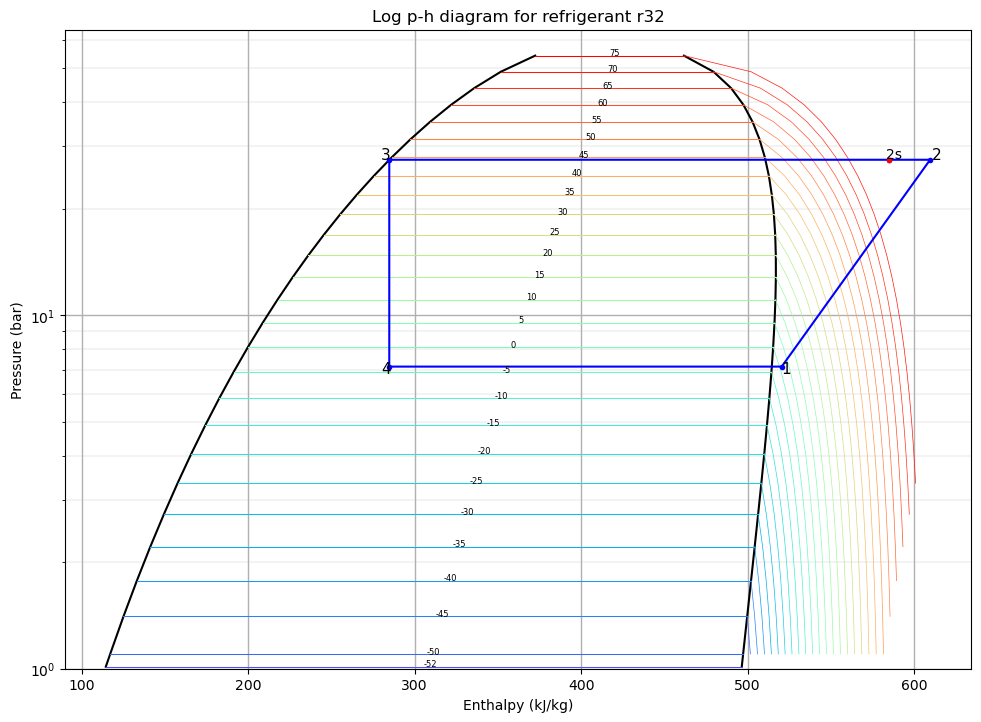

In [ ]:
# Plot cycle

ax.plot(reftable['h (kJ/kg)'] , reftable['p (bar)'], '.b')
ax.plot([h1,h2,h3,h4,h1] , [p1,p2,p3,p4,p1], 'b')
ax.plot(h2s,p2s, '.r')

ax.annotate('1', xy = (h1,p1-0.3), size = 11)
ax.annotate('2', xy = (h2+1,p2+0.1), size = 11)
ax.annotate('3', xy = (h3-5,p3+0.1), size = 11)
ax.annotate('4', xy = (h4-5,p4-0.3), size = 11)

if not isentropic_efficiency == 1:
    ax.annotate('2s', xy = (h2s-2,p2s+0.3))

fig

Calculating the refrigerant mass flow rate in case of sink type water, the volume flow of the water in $kg/s$ and $m^3/s$ respecitively. Assuming $\rho_{water} = 998 \: kg/m^3$ and $c = 4.2 \: kJ/kgK$.

In [ ]:
pressureratio

3.845520099863058

In [ ]:
mass_flowrate_refrigerant_kgs = inputs.capacity/delta_h_condensor
RHO_C = 998*4.2
volume_rate_water_m3s = inputs.capacity / ((inputs.sink_temp - inputs.sink_temp_return)*RHO_C)
electric_power_kw = inputs.capacity/cop
cooling_capacity_kw = mass_flowrate_refrigerant_kgs * delta_h_evaporator
eer = cooling_capacity_kw/electric_power_kw

### Part load conditions

Part load behaviour for inverter heat pumps is evaluated using the calculation methods given in EN-15316, assuming the following default values:
- Degradation coefficient $ C_D = 0.2 $
- Optimal part load ratio $plr_{opt} = 0.6 $
- Minimum part load ratio for continuous operation $plr_{min} = 0.2 $


### SCOP
In EN-14825 (2022), default calculation methods are given for the determination of the seasonal coefficient of performance (SCOP). It should be noted that these methods yield only a rough estimation for SCOP, based on three standard climates. Real SCOP values can differ strongly from the output of this calculation. \
The SCOP is defined as follows:

\begin{equation}

SCOP = \frac{Q_H}{Q_{HE}}

\end{equation}

Where:\
$Q_H$ is the yearly heat demand of the building (kWh)\
$Q_{HE}$ is the yearly energy usage of the heat pump (kWh)

Furthermore:

\begin{equation}

Q_H = P_{design} \cdot H_{HE}

\end{equation}

Where:\
$P_{design}$ is the design heat load of the building\
$H_{HE}$ is the time the heat pump is active (h)

Default values are given for $H_{HE}$ in EN-14825, based on the type of source and sink, the capacity, and the climate the heat pump is installed in.

<center>

|Tye source/sink|Average climate|Warmer climate|Colder climate|
|-|-|-|-|
Air/air, <12 kW|1400|1400|2100|
Air/air, >12 kW|1400|1400|2100|
Air/water, <400 kW|2066|1336|2465|
Water/water, <400 kW|2066|1336|2465|
Water/air|1400|1400|2100|

</center>

Furthermore:

\begin{equation}

Q_{HE} = \frac{Q_H}{SCOP_{on}} + Q_{aux}

\end{equation}

Where $Q_{aux}$ (kWh) is the energy used by the heat pump in different modes than normal operation (Thermostat-off mode, Standby mode, Crankcase heater mode, Off mode). Values can be given by the manufacturer, but this is not often the case. Default values are given in EN-14825. \
And:

\begin{equation}

SCOP_{on} = \frac{\Sigma^{n}_{j=1} h_j[P_h (T_j)]}{\Sigma^{n}_{j=1} h_j [ \frac{P_h (T_j)}{COP_{bin} (T_j)} ] }

\end{equation}

Where:\
$j$ is the so called bin number representing an outside temperature $T_j$, \
$h_j$ is the yearly amount of hours $T_j$ is applicable for the chosen climate, \
$P_h(T_j)$ is the power used by the heat pump for bin $j$, \
$COP_{bin} (T_j)$ is the coefficient of performance for the corresponding bin $j$.

Again, default values are given for $h_j$. $COP_{bin}$ values are calculated using the part load parameters mentioned above. Further details can be found in EN-14825.

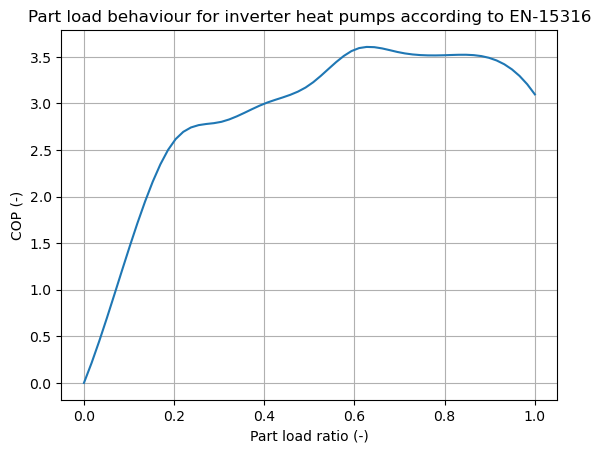

In [ ]:
[COPbin_toplot, plotrange, scop] = scopcalc.getscop(cop)

xx = numpy.linspace(0,1,60)
func = interpolate.interp1d(plotrange, COPbin_toplot, kind = 'cubic') #smooth it a little
yy = func(xx)

plt.plot(xx, yy)
plt.title('Part load behaviour for inverter heat pumps according to EN-15316')
plt.xlabel('Part load ratio (-)')
plt.ylabel('COP (-)')
plt.grid()

In [ ]:
outputtable = pd.DataFrame(
    [
        ['COP',str(round(cop,2))],
        ['SCOP', round(scop,2)],
        ['Carnot COP', round(cop_carnot,2)], 
        ['Carnot efficiency (%)', round(carnot_efficiency,3)*100], 
        ['Electric power (kW)', round(electric_power_kw,1)], 
        ['Cooling capacity (kW)', round(cooling_capacity_kw,1)],
        ['EER', round(eer,2)],
        ['Refrigerant mass flow rate (kg/s)', round(mass_flowrate_refrigerant_kgs,4)],
        [ 'Water volume flow rate (kg/s)', round(volume_rate_water_m3s,5)]
    ]   
)

outputtable.columns = ['Output', 'value']

In [ ]:
outputtable

,Output,value
0,COP,3.1
1,SCOP,3.09
2,Carnot COP,6.57
3,Carnot efficiency (%),47.1
4,Electric power (kW),3.9
5,Cooling capacity (kW),8.7
6,EER,2.25
7,Refrigerant mass flow rate (kg/s),0.037
8,Water volume flow rate (kg/s),0.00041


In [ ]:
inputs.inputtable

,0,1
0,Sink,Water
1,Source,Water
2,Sink temperature (°C),37
3,Sink temperature (return) (°C),30
4,Source temperature (°C),2
5,Refrigerant,r32
6,Capacity (kW),12


In [ ]:
reftable

,T (°C),p (bar),h (kJ/kg),s (kJ/kgK),x
point,,,,,
1,1,7.151,520.426246,2.210249,-
2s,93.346413,27.499314234120725,584.847371,2.210249,-
2,113.399227,27.499314234120725,609.547142,2.264522,-
3,44.2911757253092,27.499314234120725,284.7931160521617,1.2803217597870407,0
4,1,7.151,284.7931160521617,1.315397,0.285401
